# SPAD nonlinearity after the data are corrected for dead time and background

## Definitions

In [1]:
import sys
import os
import numpy as np
import scipy
import sympy as sp
from sympy.parsing.mathematica import mathematica
from sympy.stats import Normal, density
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from scipy.stats import norm, ks_1samp
from numpy.fft import fft, ifft, fftshift, ifftshift
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable, get_cmap
from lmfit import Model
from lmfit.parameter import Parameters
from functools import partial
from importlib.metadata import version

%matplotlib inline

import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
pkgs = ['numpy', 'scipy', 'matplotlib', 'sympy', 'lmfit']
print(f'python: {sys.version}')
for p in pkgs:
    print(p+': '+sys.modules[p].__version__)

python: 3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
numpy: 1.21.5
scipy: 1.7.3
matplotlib: 3.5.1
sympy: 1.10.1
lmfit: 1.0.3


The time unit here is 1 μs to cover count rates and dead time well within floating point precision. The graphs show counts per second.

In [2]:
meas_time = 20. # seconds
reps = 30

In [3]:
def RateNP(mu,dt):
    return 1./(1/mu + dt)

def InvRateNP(r,dt):
    return 1./(1/r-dt)

def NonlinearityModel(f,mu,dc,*pars):
    ra  = f(mu/2+dc,*pars)
    rab = f(mu+dc,*pars)
    return (rab,(2*ra/rab)-1.)

def FitFuncNP(r,dc,dt):
    mu = InvRateNP(r,dt)
    return NonlinearityModel(RateNP,mu-dc,dc,dt)[1]

def CorrectRates(r,dc,dt):
    return (InvRateNP(r,dt) - dc)

Gaussian PDF with mean $m$ and standard deviation $s$

In [4]:
def Gauss_pdf(x,m,s):
    return 1/sp.sqrt(2*sp.pi*s**2)*sp.exp(-(x-m)**2/(2*s**2))

## Data import and fitting

In [5]:
files = \
['AQRH.txt',
 'AQ4C.txt',
 'COUNT.txt',
 'ID120.txt']
names = list(map(os.path.basename,files))

In [6]:
dat = [np.genfromtxt(f, encoding='utf-8-sig') for f in files]
for i,d in enumerate(dat):
    dat[i] = np.array(np.split(d, len(d)/reps))

In [7]:
delta_raw = [(d[:,:,0]+d[:,:,1])/d[:,:,2]-1. for d in dat];

rate_means = [np.mean(d[:,:,2]/meas_time, axis=1)*1e-6 for d in dat]
delta_means = [np.mean(delta, axis=1) for delta in delta_raw]
delta_errs = [np.std(delta, axis=1, ddof=1)/np.sqrt(reps) for delta in delta_raw]

### Fit the values $R_0$ and $\tau$

In [8]:
modelNP = Model(FitFuncNP)

paramsNP = [Parameters() for i in range(len(rate_means))]

for pNP, rat in zip(paramsNP, rate_means):
    pNP.add('dc', value=1e-4, min=0., max=np.inf)
    pNP.add('dt', value=0.02, min=0., max=1./np.max(rat))

resultsNP = [modelNP.fit(d, r=r, params=p, weights=1./ye)
             for d,r,ye,p in zip(delta_means,rate_means,delta_errs,paramsNP)]

In [9]:
dc_fit = [r.best_values['dc'] for r in resultsNP]
dt_fit = [r.best_values['dt'] for r in resultsNP]

## Model of the corrected nonlinearity

Symbolic variables:
* $\Phi$ – incident rate
* $R_0$ – background rate (dark counts)
* $T$ – measurement time
* $\delta$ — shifted nonlinearity (see below)

In [10]:
s_f, s_dc, s_T = sp.symbols('\Phi R_0 T', positive=True)
s_d, s_r = sp.symbols('\delta r', real=True)

### Low rates

For incident rates $\Phi \ll 1/\tau$, we can assume that $R^\mathrm{det} \approx \Phi + R_0$. For practical calculations, we also shift the nonlinearity:
\begin{align}
\delta &= \frac{\Phi_\mathrm{A} + \Phi_\mathrm{B}}{\Phi_\mathrm{AB}}, \\
\Delta^\mathrm{corr} &= \delta - 1.
\end{align}
Now, we need to calculate the distribution of $\delta$. We assume that $T$ is long enough for the accumulated counts $(R^\mathrm{det}T)$ to be approximately normally distributed. To estimate $\Phi$ we work with corrected values $R^\mathrm{corr} = R^\mathrm{det} - R_0$, where $R^\mathrm{det} \sim \mathcal{N}(\Phi + R_0, (\Phi + R_0)/T)$. Then, the measured values of the corrected rates are also normal, and assuming a balanced splitting of an incident rate $\Phi$,
\begin{align}
R^\mathrm{corr}_\mathrm{AB} &\sim \mathcal{N}(\Phi, (\Phi+R_0)/T), \\
R^\mathrm{corr}_\mathrm{A,B} &\sim \mathcal{N}(\Phi/2, ((\Phi/2) + R_0)/T), \\
R^\mathrm{corr}_\mathrm{A} + R^\mathrm{corr}_\mathrm{B} &\sim \mathcal{N}(\Phi, (\Phi + 2 R_0)/T).
\end{align}
Let us denote the PDF of a normal variable with mean $\mu$ and variance $\sigma^2$ as
$$
p_\mathcal{N}[\mu,\sigma^2](x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left( -\frac{(x-\mu)^2}{2\sigma^2} \right).
$$
Let us use the PDF transformation of two independent random variables to calculate the result,
$$
p(\delta) = \int_{-\infty}^\infty p_\mathcal{N}[\Phi, (\Phi + 2 R_0)/T](\delta \times r) \times p_\mathcal{N}[\Phi, (\Phi + R_0)/T](r) \times |r| \mathrm{d}r.
$$

In [11]:
d_pdf_sym = sp.simplify(
    sp.integrate(Gauss_pdf(s_r*s_d, s_f, sp.sqrt((s_f+2*s_dc)/s_T)) \
                 * Gauss_pdf(s_r, s_f, sp.sqrt((s_f+s_dc)/s_T)) \
                 * abs(s_r),
              (s_r, -sp.oo, sp.oo))
)
display(d_pdf_sym)

sqrt(2)*(sqrt(pi)*sqrt(T)*\Phi*(R_0*\delta + 2*R_0 + \Phi*\delta + \Phi)*exp(T*\Phi**2*(R_0*\delta + 2*R_0 + \Phi*\delta + \Phi)**2/(2*(R_0 + \Phi)*(2*R_0 + \Phi)*(R_0*\delta**2 + 2*R_0 + \Phi*\delta**2 + \Phi)))*erf(sqrt(2)*sqrt(T)*\Phi*(R_0*\delta + 2*R_0 + \Phi*\delta + \Phi)/(2*sqrt(2*R_0**3*\delta**2 + 4*R_0**3 + 5*R_0**2*\Phi*\delta**2 + 8*R_0**2*\Phi + 4*R_0*\Phi**2*\delta**2 + 5*R_0*\Phi**2 + \Phi**3*\delta**2 + \Phi**3))) + sqrt(2)*sqrt(2*R_0**3*\delta**2 + 4*R_0**3 + 5*R_0**2*\Phi*\delta**2 + 8*R_0**2*\Phi + 4*R_0*\Phi**2*\delta**2 + 5*R_0*\Phi**2 + \Phi**3*\delta**2 + \Phi**3))*exp(-T*\Phi**2*(3*R_0 + 2*\Phi)/(2*(R_0 + \Phi)*(2*R_0 + \Phi)))/(2*pi*(R_0*\delta**2 + 2*R_0 + \Phi*\delta**2 + \Phi)**(3/2))

Now we need to factor in the second exponential, because the first exponential alone may cause floating-point overflow. We will sum their arguments separately.

In [12]:
# create an input code from the symbolic expresssion
str(d_pdf_sym).replace('\\Phi','s_f').replace('\\delta', 's_d').replace('R_0', 's_dc').replace('T', 's_T')\
.replace('sqrt', 'sp.sqrt').replace('erf', 'sp.erf').replace('exp', 'sp.exp').replace('pi', 'sp.pi')

'sp.sqrt(2)*(sp.sqrt(sp.pi)*sp.sqrt(s_T)*s_f*(s_dc*s_d + 2*s_dc + s_f*s_d + s_f)*sp.exp(s_T*s_f**2*(s_dc*s_d + 2*s_dc + s_f*s_d + s_f)**2/(2*(s_dc + s_f)*(2*s_dc + s_f)*(s_dc*s_d**2 + 2*s_dc + s_f*s_d**2 + s_f)))*sp.erf(sp.sqrt(2)*sp.sqrt(s_T)*s_f*(s_dc*s_d + 2*s_dc + s_f*s_d + s_f)/(2*sp.sqrt(2*s_dc**3*s_d**2 + 4*s_dc**3 + 5*s_dc**2*s_f*s_d**2 + 8*s_dc**2*s_f + 4*s_dc*s_f**2*s_d**2 + 5*s_dc*s_f**2 + s_f**3*s_d**2 + s_f**3))) + sp.sqrt(2)*sp.sqrt(2*s_dc**3*s_d**2 + 4*s_dc**3 + 5*s_dc**2*s_f*s_d**2 + 8*s_dc**2*s_f + 4*s_dc*s_f**2*s_d**2 + 5*s_dc*s_f**2 + s_f**3*s_d**2 + s_f**3))*sp.exp(-s_T*s_f**2*(3*s_dc + 2*s_f)/(2*(s_dc + s_f)*(2*s_dc + s_f)))/(2*sp.pi*(s_dc*s_d**2 + 2*s_dc + s_f*s_d**2 + s_f)**(3/2))'

In [13]:
first_exp_arg = sp.simplify(
    -s_T*s_f**2*(3*s_dc + 2*s_f)/(2*(s_dc + s_f)*(2*s_dc + s_f)) \
    +s_T*s_f**2*(s_dc*s_d + 2*s_dc + s_f*s_d + s_f)**2/(2*(s_dc + s_f)*(2*s_dc + s_f)*(s_dc*s_d**2 + 2*s_dc + s_f*s_d**2 + s_f))
)
display(first_exp_arg)

T*\Phi**2*(-\delta**2 + 2*\delta - 1)/(2*(R_0*\delta**2 + 2*R_0 + \Phi*\delta**2 + \Phi))

In [14]:
d_pdf_sym = sp.sqrt(2)*(sp.sqrt(sp.pi)*sp.sqrt(s_T)*s_f*(s_dc*s_d + 2*s_dc + s_f*s_d + s_f)\
            *sp.exp(first_exp_arg)\
            *sp.erf(sp.sqrt(2)*sp.sqrt(s_T)*s_f*(s_dc*s_d + 2*s_dc + s_f*s_d + s_f)/(2*sp.sqrt(2*s_dc**3*s_d**2 + 4*s_dc**3 + 5*s_dc**2*s_f*s_d**2 + 8*s_dc**2*s_f + 4*s_dc*s_f**2*s_d**2 + 5*s_dc*s_f**2 + s_f**3*s_d**2 + s_f**3)))\
            + sp.sqrt(2)*sp.exp(-s_T*s_f**2*(3*s_dc + 2*s_f)/(2*(s_dc + s_f)*(2*s_dc + s_f)))\
                        *sp.sqrt(2*s_dc**3*s_d**2 + 4*s_dc**3 + 5*s_dc**2*s_f*s_d**2 + 8*s_dc**2*s_f + 4*s_dc*s_f**2*s_d**2 + 5*s_dc*s_f**2 + s_f**3*s_d**2 + s_f**3))\
/(2*sp.pi*(s_dc*s_d**2 + 2*s_dc + s_f*s_d**2 + s_f)**(3/2))
display(d_pdf_sym)

sqrt(2)*(sqrt(pi)*sqrt(T)*\Phi*(R_0*\delta + 2*R_0 + \Phi*\delta + \Phi)*exp(T*\Phi**2*(-\delta**2 + 2*\delta - 1)/(2*(R_0*\delta**2 + 2*R_0 + \Phi*\delta**2 + \Phi)))*erf(sqrt(2)*sqrt(T)*\Phi*(R_0*\delta + 2*R_0 + \Phi*\delta + \Phi)/(2*sqrt(2*R_0**3*\delta**2 + 4*R_0**3 + 5*R_0**2*\Phi*\delta**2 + 8*R_0**2*\Phi + 4*R_0*\Phi**2*\delta**2 + 5*R_0*\Phi**2 + \Phi**3*\delta**2 + \Phi**3))) + sqrt(2)*sqrt(2*R_0**3*\delta**2 + 4*R_0**3 + 5*R_0**2*\Phi*\delta**2 + 8*R_0**2*\Phi + 4*R_0*\Phi**2*\delta**2 + 5*R_0*\Phi**2 + \Phi**3*\delta**2 + \Phi**3)*exp(-T*\Phi**2*(3*R_0 + 2*\Phi)/((2*R_0 + \Phi)*(2*R_0 + 2*\Phi))))/(2*pi*(R_0*\delta**2 + 2*R_0 + \Phi*\delta**2 + \Phi)**1.5)

We arrive at the PDF $p(\delta)$, which is a function of $\Phi$ (equivalent to $R^\mathrm{corr}_\mathrm{AB}$), $R_0$, and $T$.

In [15]:
# convert the symbolic expression into a numerical function
d_pdf = sp.lambdify([s_d, s_f, s_dc, s_T], d_pdf_sym)

Here we use the distribution of $\delta$ to calculate the distribution of the avarege value of $N$ values of $\Delta$. We know that the PDF of $(X+Y)$ is a convolution of the respective PDFs of $X, Y$. Therefore we need to calculate an $(N-1)$-fold convolution of $p(\delta)$. As convolution corresponds to multiplication in the Fourier image, we can write
$$
p\left( \sum_{i=1}^N \delta_i \right) = \mathcal{F}^{-1} \left( \mathcal{F}(p(\delta))^N\right)
$$

In [16]:
# probability density distribution of the sum of deltas
def GetNumericalDist(f, dc, T, nConv, d_range=1000., sam=100000+1):
    d_sp = np.linspace(-d_range, d_range, sam)
    u = 2*d_range/(sam-1)
    d_dist = ifftshift( d_pdf(d_sp, f, dc, T) )
    d_dist = (u**nConv)*(fft(d_dist)**(nConv+1))
    d_dist = np.real(fftshift(ifft(d_dist)))
    return (d_sp, d_dist)

# based on the distribution above, calculate the estimators
def GetNumMeanInterval(f, dc, T, nVals, confid=erf(1/np.sqrt(2)), d_range=1000., sam=100000+1):
    d_sp, d_dist = GetNumericalDist(f, dc, T, nVals-1, d_range, sam)
    u = 2*d_range/(sam-1)
    m = sum(d_sp*d_dist*u)
    
    mi = round(m/u+(sam-1)/2)
    i1 = i2 = mi
    
    s = d_dist[mi]
    while s < (confid/u):
        if (d_dist[i1] > d_dist[i2]):
            i1 -= 1
            s += d_dist[i1]
        else:
            i2 += 1
            s += d_dist[i2]
    
    # because the mean nonlinearity is divided by N and shifted, apply these now
    m = m/nVals - 1.
    d_sp = d_sp/nVals - 1.
    
    # return the mean and the lower and upper bounds of the confidence interval
    return np.array([m, d_sp[i1], d_sp[i2]])

### High rates

#### Standard deviation of $\delta$

For higher rates, we assume a normal distribution of $\delta$ and the full correction
$$
R^\mathrm{corr} = \frac{1}{\frac{1}{R^\mathrm{det}} - \tau} - R_0.
$$

In [17]:
s_tau, s_ra, s_rb, s_rab, s_Fa, s_Fb, s_Fab = \
    sp.symbols(r'\tau R_a R_b R_{ab} \phi_a \phi_b \phi_{ab}', positive=True)

Here we make $\Delta^\mathrm{corr}$ a function of detected rates by substituting the corrections.

In [18]:
dlt = (s_Fa + s_Fb)/s_Fab
for c in ('a','b','ab'):
    dlt = dlt.subs(eval('s_F'+c), 1/(1/eval('s_r'+c)-s_tau)-s_dc)
display(dlt)

(-2*R_0 + 1/(-\tau + 1/R_b) + 1/(-\tau + 1/R_a))/(-R_0 + 1/(-\tau + 1/R_{ab}))

All the detected rates are normal, so we calculate the standard deviation by a linear expansion around the mean value. We recall that the detected rate have the mean $\theta$ and variance $(1-\tau\theta)^2 \theta / T$.

In [19]:
d_std = sp.sqrt(
    sum( [sp.diff(dlt, s)**2 * ((1-s_tau*s)**2 * s/s_T) for s in (s_ra,s_rb,s_rab)] )
)
d_std = d_std.subs(s_rb, s_ra) # balanced splitting
d_std = d_std.subs(s_ra, 1/(1/(s_f/2+s_dc)+s_tau))
d_std = d_std.subs(s_rab, 1/(1/(s_f+s_dc)+s_tau))
d_std = sp.simplify(d_std)
display(d_std)

sqrt(2)*sqrt(2*(R_0 + \Phi)*(\tau*(R_0 + \Phi) + 1) + (2*R_0 + \Phi)*(\tau*(2*R_0 + \Phi) + 2))/(2*sqrt(T)*\Phi)

The standard deviation of $\delta$ here is again the function of $\Phi$ (equivalent to $R^\mathrm{corr}_\mathrm{AB}$), $R_0$, $T$, and newly $\tau$.

In [20]:
d_std_gauss = sp.lambdify([s_f, s_dc, s_tau, s_T], d_std)

#### Mean value of $\delta$

We calculate the small bias in the mean value by first evaluating the mean values of the numerator and denominator of $\delta$. These are a function of the normally distributed random variables $R^\mathrm{det}_i$, $i$ = A, B, AB. 

In [21]:
def TaylorTerm(expr, x, x0, i):
    return(sp.diff(expr, x, i).subs(x, x0)*(x-x0)**i/sp.factorial(i))

$\left\langle R^\mathrm{corr}_\mathrm{A,B} \right\rangle$

In [22]:
def meanR(x0, taylor_maxOrder=2):
    
    # placeholder for the standard deviation
    s_sgma = sp.Symbol('sigma', positive=True)
    # normally distributed variable acting as the detected rate
    s_x = Normal('x', x0, s_sgma)
    
    # calculate the mean value of the Taylor expansion
    res = sum( [sp.integrate(
            TaylorTerm(1/(1/s_x-s_tau)-s_dc, s_x, x0, i)*density(s_x)(s_x),\
            (s_x, -sp.oo, sp.oo)
        )
        for i in range(taylor_maxOrder+1)]
    )
    
    res = res.subs(s_sgma, (1-s_tau*x0)*sp.sqrt(x0/s_T))
    
    return res.simplify()

$\left\langle 1/R^\mathrm{corr}_\mathrm{AB} \right\rangle$

In [23]:
def meanInvR(x0, taylor_maxOrder=2):
    
    s_sgma = sp.Symbol('sigma', positive=True)
    s_x = Normal('x', x0, s_sgma)
    
    res = sum( [sp.integrate(
            TaylorTerm(1/(1/(1/s_x-s_tau)-s_dc), s_x, x0, i)*density(s_x)(s_x),\
            (s_x, -sp.oo, sp.oo)
        )
        for i in range(taylor_maxOrder+1)]
    )

    res = res.subs(s_sgma, (1-s_tau*x0)*sp.sqrt(x0/s_T))
    
    return res.simplify()

In [24]:
mg = 2*meanR(1/(1/(s_f/2+s_dc)+s_tau))*meanInvR(1/(1/(s_f+s_dc)+s_tau)) - 1
mg = mg.simplify()
display(mg)

(-T**2*\Phi**3 + (T*\Phi + \tau*(2*R_0 + \Phi))*(T*\Phi**2 + (R_0 + \Phi)*(-\Phi*\tau + \tau*(R_0 + \Phi) + 1)))/(T**2*\Phi**3)

Taking into account these approximations,
$\tau \ll T, \tau R_0 \ll 1$,
we can simplify further by hand:

In [25]:
mgs = (s_dc + s_f)/(s_T*s_f**2)
display(mgs)

(R_0 + \Phi)/(T*\Phi**2)

In [26]:
mean_gauss = sp.lambdify([s_f,s_dc,s_tau,s_T], mgs)

### Estimator function

In [27]:
# the overall estimator of average nonlinearity
# depending on the rate, it uses the respective approximation
def delta_estimator(f, dc, tau, T, reps, confid=erf(1/np.sqrt(2))):
    if f < dc:
        return GetNumMeanInterval(f, dc, T, reps, confid)
    else:
        m = mean_gauss(f, dc, tau, T)
        s = d_std_gauss(f, dc, tau, T)/np.sqrt(reps)
        s *= np.sqrt(2)*erfinv(confid)
        return np.array([m, m-s, m+s])

## Data corrections

In [28]:
dat_C = [CorrectRates(d/meas_time*1e-6,dc,dt)*meas_time*1e6 for d,dc,dt in zip(dat,dc_fit,dt_fit)]

In [29]:
delta_raw_C = [(d[:,:,0]+d[:,:,1])/d[:,:,2]-1. for d in dat_C];

rate_means_C = [np.mean(d[:,:,2]/meas_time, axis=1)*1e-6 for d in dat_C]
delta_means_C = [np.mean(delta, axis=1) for delta in delta_raw_C]
delta_errs_C = [np.std(delta, axis=1, ddof=1)/np.sqrt(reps) for delta in delta_raw_C]

In [30]:
dat_C_scatter = [d.reshape((-1,3)) for d in dat_C]
delta_raw_C_scatter = [d.reshape((-1)) for d in delta_raw_C]

## Calculations for the plot

In [31]:
# the confidence level for the shown interval
conf_level = 0.95

In [32]:
# return the cumulative distribution function (CDF) depending on the rate
def delta_mean_cdf(f, dc, tau, T):
    if f < dc:
        d_sp, d_dist = GetNumericalDist(f, dc, T, 0)
        d_dt = d_sp[1]-d_sp[0]
        d_cum = np.cumsum(d_dist)*d_dt
        return interp1d(d_sp, d_cum)
    else:
        m = mean_gauss(f, dc, tau, T)
        s = d_std_gauss(f, dc, tau, T)
        return partial(norm.cdf, loc=m, scale=s)

In [33]:
# build a plot of the mean and confidence interval
# for every data point, also calculate the K-S statistic
est_mean = [None]*len(dat_C)
ks_vals = [None]*len(dat_C)

for i, dc, dt, rate_DET, delta_DET in \
    zip(range(len(dat_C)), dc_fit, dt_fit, rate_means_C, delta_raw_C):

    est_mean[i] = {}
    est_mean[i]['x'] = np.logspace(-1, 8, 200)
    e = map(partial(delta_estimator, dc=dc*1e6, tau=dt*1e-6, T=meas_time,
                    reps=reps, confid=conf_level), est_mean[i]['x'])
    e = np.array(list(e)).T
    est_mean[i]['means'] = e[0]
    est_mean[i]['lower'] = e[1]
    est_mean[i]['upper'] = e[2]
    
    ks_vals[i] = np.empty((rate_DET.shape[0], 2))

    for j, r, d in zip(range(len(rate_DET)), rate_DET, delta_DET):
        cdf = delta_mean_cdf(r*1e6, dc=dc*1e6, tau=dt*1e-6, T=meas_time)
        ks_vals[i][j] = ks_1samp(d, cdf)

## The main plot

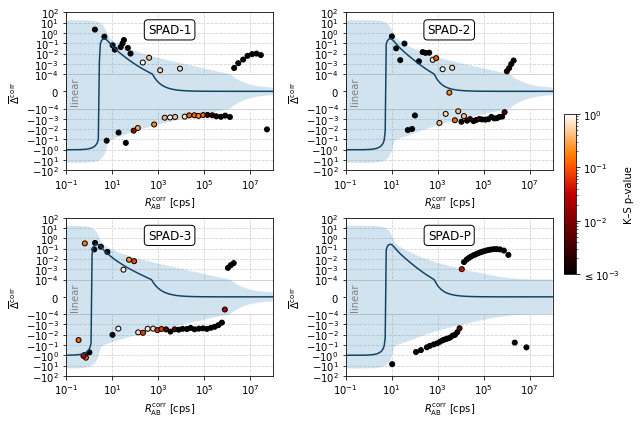

In [34]:
def PlotDeviations():
    
    symlog_th = 1e-4
    KS_th = (1e-3, 1e0)
    
    fig = plt.figure(figsize=(9, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=[2, 0.05])
    gsm = gs[0].subgridspec(2, 2, wspace=0.35, hspace=0.3)
    gsl = gs[1].subgridspec(3, 1, height_ratios=[1,2,1])
    
    titles = ['SPAD-'+str(n) for n in range(1,4)]+['SPAD-P']
    
    nrm = LogNorm(*KS_th, clip=True)
    cmap = get_cmap('gist_heat')

    ## Colorbar legend
    
    lax = fig.add_subplot(gsl[1])
    
    fig.colorbar(ScalarMappable(norm=nrm, cmap=cmap),
                    cax=lax, orientation='vertical', label='K–S p-value')
    
    def cb_ytick(x, pos):
        lx = int(np.log10(x))
        pre = ''
        if x <= KS_th[0]:
            pre = '\leq '
        return f'${pre}10^{{{lx}}}$'
        
    lax.yaxis.set_major_formatter(FuncFormatter(cb_ytick))

    ## Main axes

    for gi, rate, delta, tit, er, est, ks in \
        zip(range(4), rate_means_C, delta_means_C, titles, delta_errs_C, est_mean, ks_vals):
        
        ax = fig.add_subplot(gsm[gi])
        
        plot_range = (est['x'][0], est['x'][-1])
        
        ## Select only points visible on the log-scale

        delta = delta[rate > 0]
        er = er[rate > 0]
        ks = ks[rate > 0]

        rate = rate[rate > 0]

        ## Set up axes

        ax.set_xscale('log')
        ax.set_yscale('symlog', linthresh=symlog_th, linscale=1.5)

        ax.grid(visible=True, which='major', color='lightgray', linestyle='--', zorder=0)
        ax.set_axisbelow(True)

        ax.set_xlim(*plot_range)
        ax.set_ylim(-1e2, 1e2)
        
        ## Linear region patches

        axes_break = patches.Rectangle((plot_range[0], -symlog_th), plot_range[1]-plot_range[0],
                                       2*symlog_th, fc='w', ec='lightgrey')
        ax.add_patch(axes_break)

        ax.annotate('linear', xy=(0.02, 0.5), xycoords='axes fraction', ha='left', va='center', fontsize=10,
                   color='gray', rotation=90)

        ## Plot the confidence interval and expected value

        ax.fill_between(est['x'], est['lower'], est['upper'], alpha=0.2, zorder=1)
        ax.plot(est['x'], est['means'], c='#114366', zorder=2)
        
        ## Data and coloring
        
        clrs = cmap(nrm(ks[:,1]))
        
        p = ax.scatter(rate*1e6, delta, s=25., c=clrs, edgecolors='k')

        ## Labels

        ax.set_xlabel(r'$R^{\mathrm{corr}}_{\mathrm{AB}}$ [cps]')
        ax.set_ylabel(r'$\overline{\Delta}^{\mathrm{corr}}$')

        ann = ax.annotate(tit, xy=(0.5, 0.93), xycoords='axes fraction', ha='center', va='top',
                          fontsize=12, bbox=dict(boxstyle='round', color='w', ec='k'))


    gs.tight_layout(fig)
    
    plt.show()
    
    return fig

fig1_means = PlotDeviations()